In the previous tutorial we learned how to retrieve a single value for a point, but often times we are interested in querying values for multiple points or locations in space. To illustrate this workflow, we will create a `for` loop based on the previous tutorial. 

In this example we will retrieve soil physical properties, including sand and clay content for several stations of the Kansas Mesonet (https://mesonet.k-state.edu). Soil physical properties like sand and clay percentage are easy to measure and can be used to estimate other soil physical properties that are more difficult to measure, like water holding capacity. To compare different gridded products, we will use the SoilGrids and the Polaris datasets.

If you want to learn more about the network and the soil physical properties I recommend reading the following two peer-reviewed articles: Parker et al. (2022) and Patrignani et al. (2020)


In [56]:
# Import modules
import ee
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
# Authenticate
#ee.Authenticate()

# Initialize the library.
ee.Initialize()

## Load GEE datasets

In [52]:
# Load the SoilGrids dataset from GEE
soilgrids_sand = ee.Image("projects/soilgrids-isric/sand_mean")
soilgrids_clay = ee.Image("projects/soilgrids-isric/clay_mean")

# Load Polaris dataset
# Note: It's easier to load the image than the ImageCollection.
# Check the 'id' of each feature in the ImageCollection to get the link for the Image
# Code for ImageCollection: ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean')
polaris_sand = ee.Image('projects/sat-io/open-datasets/polaris/sand_mean/sand_0_5')
polaris_clay = ee.Image('projects/sat-io/open-datasets/polaris/clay_mean/clay_0_5')


Before requesting data using the loaded GEE products, it is necessary to understand the nature of these datasets:

#### Soil Grids

This dataset has a 250-meter spatial resolution (Poggio et al., 2021) and returns an image, where each band represents a depth for the given variable.  After sampling the image, GEE returns a FeatureCollection with a single feature (we the `.first()` function to access this information). Run this line of code to inspect the output:

```python
soilgrids_sand.getInfo()
```

#### Polaris

This dataset has a spatial resolution of 30-meters (Chaney et al., 2019). The way we are calling this dataset it returns an Image, where each band represents a depth for a given variable. Again, after sampling the image, GEE returns a FeatureCollection with a single feature (we the `.first()` function to access this information).Run this line of code to inspect the output:

```python
polaris_clay.getInfo()
```


Different teams aggregate data using different structures, so before using these or any other products available in GEE is important to read the documentation and inspect the data with a few examples.

## Station data

In [17]:
# Create dictionary with station metadata

stations = [
    {'name': 'Ashland Bottoms', 'latitude': 39.125773, 'longitude': -96.63653},
    {'name': 'Belleville 2W', 'latitude': 39.81409, 'longitude': -97.675093},
    {'name': 'Colby', 'latitude': 39.39247, 'longitude': -101.06864},
    {'name': 'Garden City', 'latitude': 37.99733, 'longitude': -100.81514},
    {'name': 'Gypsum', 'latitude': 38.72522, 'longitude': -97.44415},
    {'name': 'Hutchinson 10SW', 'latitude': 37.93097, 'longitude': -98.02},
    {'name': 'Manhattan', 'latitude': 39.20857, 'longitude': -96.59169},
    {'name': 'Ottawa 2SE', 'latitude': 38.54268, 'longitude': -95.24647},
    {'name': 'Parsons', 'latitude': 37.36875, 'longitude': -95.28771},
    {'name': 'Rossville 2SE', 'latitude': 39.11661, 'longitude': -95.91572},
    {'name': 'Silver Lake 4E', 'latitude': 39.09213, 'longitude': -95.78153},
    {'name': 'Tribune 6NE', 'latitude': 38.53041, 'longitude': -101.66434},
    {'name': 'Woodson', 'latitude': 37.8612, 'longitude': -95.7836}
]


## Request soil data for each station

In [63]:
# We will retrieve both datasets at 250-meter resolution to match the 
# coarser dataset.

# Iterate over each station metadata
for k,station in enumerate(stations):
    
    # Display current state of the loop
    print(f"Requesting data for {station['name']}")
    
    # Convert geographic coordinates into a Point geometry
    # following the x,y notation
    point = ee.Geometry.Point([station['longitude'], station['latitude']])
    
    # Soil Grids: Sample image and then select first and only feature with property value
    stations[k]['sand_soilgrids'] = soilgrids_sand.sample(point, 250).first().getNumber('sand_0-5cm_mean').multiply(0.1).getInfo()
    stations[k]['clay_soilgrids'] = soilgrids_clay.sample(point, 250).first().getNumber('clay_0-5cm_mean').multiply(0.1).getInfo()

    # Polaris: Sample image and then select first and only feature with property value
    stations[k]['sand_polaris'] = polaris_sand.sample(point, 250).first().getNumber('b1').getInfo()
    stations[k]['clay_polaris'] = polaris_clay.sample(point, 250).first().getNumber('b1').getInfo()
    
    

Requesting data for Ashland Bottoms
Requesting data for Belleville 2W
Requesting data for Colby
Requesting data for Garden City
Requesting data for Gypsum
Requesting data for Hutchinson 10SW
Requesting data for Manhattan
Requesting data for Ottawa 2SE
Requesting data for Parsons
Requesting data for Rossville 2SE
Requesting data for Silver Lake 4E
Requesting data for Tribune 6NE
Requesting data for Woodson


## Create DataFrame

In [66]:
# Convert dictionary into a dataframe for easier visualization
df = pd.DataFrame(stations)
df.head(3)

,name,latitude,longitude,sand,clay,sand_soilgrids,clay_soilgrids,sand_polaris,clay_polaris
0,Ashland Bottoms,39.125773,-96.636530,15.4,29.2,15.4,29.2,3.831753,32.519817
1,Belleville 2W,39.814090,-97.675093,9.9,35.6,9.9,35.6,7.110556,24.645983
2,Colby,39.392470,-101.068640,17.1,33.2,17.1,33.2,25.102043,19.496693


## Create Figure

Now that we have the data from both datasets, let compare them

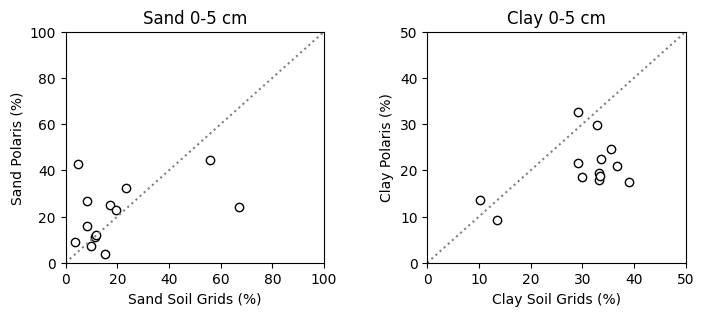

In [79]:
plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.title('Sand 0-5 cm')
plt.scatter(df['sand_soilgrids'], df['sand_polaris'],facecolor='w',edgecolor='k')
plt.xlabel('Sand Soil Grids (%)')
plt.ylabel('Sand Polaris (%)')
plt.xlim([0,100])
plt.ylim([0,100])
plt.axline((0,0), slope=1, color='grey', linestyle=':')

plt.subplot(1,2,2)
plt.title('Clay 0-5 cm')
plt.scatter(df['clay_soilgrids'], df['clay_polaris'],facecolor='w',edgecolor='k')
plt.xlabel('Clay Soil Grids (%)')
plt.ylabel('Clay Polaris (%)')
plt.xlim([0,50])
plt.ylim([0,50])
plt.axline((0,0), slope=1, color='grey', linestyle=':')

plt.subplots_adjust(wspace=0.4)
plt.show()

## References

- Poggio, L., De Sousa, L. M., Batjes, N. H., Heuvelink, G. B., Kempen, B., Ribeiro, E., & Rossiter, D. (2021). SoilGrids 2.0: producing soil information for the globe with quantified spatial uncertainty. Soil, 7(1), 217-240.

- Parker, N., Kluitenberg, G. J., Redmond, C., & Patrignani, A. (2022). A database of soil physical properties for the Kansas Mesonet. Soil Science Society of America Journal, 86(6), 1495-1508. https://doi.org/10.1002/saj2.20465


- Patrignani, A., Knapp, M., Redmond, C., & Santos, E. (2020). Technical overview of the Kansas Mesonet. Journal of Atmospheric and Oceanic Technology, 37(12), 2167-2183. https://doi.org/10.1175/JTECH-D-19-0214.1


- Chaney, N. W., Minasny, B., Herman, J. D., Nauman, T. W., Brungard, C. W., Morgan, C. L., ... & Yimam, Y. (2019). POLARIS soil properties: 30‐m probabilistic maps of soil properties over the contiguous United States. Water Resources Research, 55(4), 2916-2938.